In [1]:
import numpy as np
from scipy.spatial import cKDTree
from numpy import genfromtxt
import matplotlib.pyplot as plt
from __future__ import print_function, division
import math, csv

In [2]:
a = np.loadtxt('inittopo_groundtruthfine.txt')
b = np.loadtxt('initial_elev.txt')
z = np.loadtxt('final_elev.txt')

z = np.where(z > -1000, z, -5000)
z[90:,:55] = -5000 
z[:,110:] = -5000

In [3]:
print(a.shape)
print(b.shape)

(20, 20)
(129, 141)


In [4]:
d = np.empty_like(a)

In [5]:
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

In [6]:
d = bin_ndarray(a, new_shape=(10,10), operation='mean')

In [7]:
def resize_array(a, new_rows, new_cols): 
    '''
    This function takes an 2D numpy array a and produces a smaller array 
    of size new_rows, new_cols. new_rows and new_cols must be less than 
    or equal to the number of rows and columns in a.
    '''
    rows = len(a)
    cols = len(a[0])
    yscale = float(rows) / new_rows 
    xscale = float(cols) / new_cols

    # first average across the cols to shorten rows    
    new_a = np.zeros((rows, new_cols)) 
    for j in range(new_cols):
        # get the indices of the original array we are going to average across
        the_x_range = (j*xscale, (j+1)*xscale)
        firstx = int(the_x_range[0])
        lastx = int(the_x_range[1])
        # figure out the portion of the first and last index that overlap
        # with the new index, and thus the portion of those cells that 
        # we need to include in our average
        x0_scale = 1 - (the_x_range[0]-int(the_x_range[0]))
        xEnd_scale =  (the_x_range[1]-int(the_x_range[1]))
        # scale_line is a 1d array that corresponds to the portion of each old
        # index in the_x_range that should be included in the new average
        scale_line = np.ones((lastx-firstx+1))
        scale_line[0] = x0_scale
        scale_line[-1] = xEnd_scale
        # Make sure you don't screw up and include an index that is too large
        # for the array. This isn't great, as there could be some floating
        # point errors that mess up this comparison.
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lastx = lastx - 1
        # Now it's linear algebra time. Take the dot product of a slice of
        # the original array and the scale_line
        new_a[:,j] = np.dot(a[:,firstx:lastx+1], scale_line)/scale_line.sum()

    # Then average across the rows to shorten the cols. Same method as above.
    # It is probably possible to simplify this code, as this is more or less
    # the same procedure as the block of code above, but transposed.
    # Here I'm reusing the variable a. Sorry if that's confusing.
    a = np.zeros((new_rows, new_cols))
    for i in range(new_rows):
        the_y_range = (i*yscale, (i+1)*yscale)
        firsty = int(the_y_range[0])
        lasty = int(the_y_range[1])
        y0_scale = 1 - (the_y_range[0]-int(the_y_range[0]))
        yEnd_scale =  (the_y_range[1]-int(the_y_range[1]))
        scale_line = np.ones((lasty-firsty+1))
        scale_line[0] = y0_scale
        scale_line[-1] = yEnd_scale
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lasty = lasty - 1
        a[i:,] = np.dot(scale_line, new_a[firsty:lasty+1,])/scale_line.sum() 

    return a

In [8]:
c = resize_array(b, 20, 20)
y = resize_array(z, 20, 20)

In [9]:
print(c.shape)
print(y.shape)

(20, 20)
(20, 20)


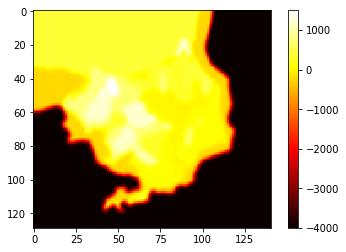

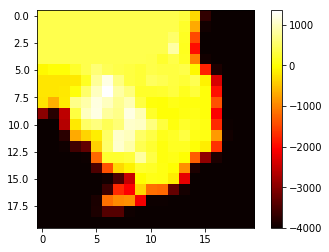

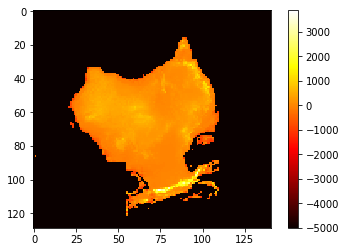

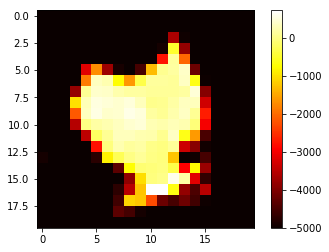

In [10]:
im = plt.imshow(b, cmap='hot', interpolation='nearest')
plt.colorbar(im)
plt.show()
plt.close()
im = plt.imshow(c, cmap='hot', interpolation='nearest')
plt.colorbar(im)
plt.show()
plt.close()
im = plt.imshow(z, cmap='hot', interpolation='nearest')
plt.colorbar(im)
plt.show()
plt.close()
im = plt.imshow(y, cmap='hot', interpolation='nearest')
plt.colorbar(im)
plt.show()
plt.close()

In [11]:
# j = 14
# k = 3

# x = np.full((j,k), -4000)
# c[0:j, 0:k] = x

# y = np.full((k,j), -4000)
# c[0:k, 0:j] = y

# plt.imshow(c, cmap='hot', interpolation='nearest')
# plt.show()
# plt.close()

In [12]:
y[6:12,4:15] = c[6:12,4:15]

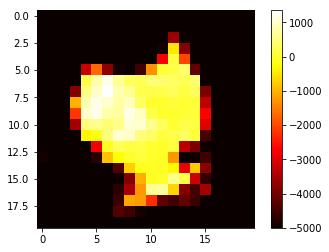

In [13]:
im = plt.imshow(y, cmap='hot', interpolation='nearest')
plt.colorbar(im)
plt.show()

plt.close()

In [14]:
np.savetxt('init_topo_fused.txt', y, fmt='%.1f')
np.savetxt('carmen_2020.txt', c, fmt='%.1f')
np.savetxt('final_elev_filtered_ocean.txt', z)